In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def eta(lamb):
    """computes eta(lamb) = -lamb"""
    return -lamb

def eta_inv(eta):
    """recovers lamb"""
    return -eta

def eta_inv_jac(eta):
    """compute the jacobian of eta^{-1}(eta)"""
    return -1


In [4]:
#Class computing the posterior of \eta(\theta) given observations

class Exponential():
    def __init__(self, eta_prior_mean, eta_prior_cov):
        self.eta_prior_mean = eta_prior_mean #prior on eta
        self.eta_prior_cov = eta_prior_cov #prior on cov of eta
        self.num_params = 1

        self.dr_ = lambda x : 1.
        self.db_ = lambda x : 0.
        self.ddr_ = lambda x : 0.

        self.m = lambda x : x
        self.dmmdr = lambda x : 2 * x

        return
    
    def posterior(self, data):
        assert data.ndim == 1, "Data must be 1-dimensional"

        Lambda = 0.
        Nu = 0.

        T = len(data)

        for x in data:
            Lambda += (1/T) * self.dr_(x) * self.m(x)**2 * self.dr_(x)
            Nu += (2/T) * (self.dr_(x) * self.db_(x) + self.dmmdr(x))

        eta_post_cov = ((self.eta_prior_cov)**(-1) + 2 * T * Lambda)**(-1)

        eta_post_mean = eta_post_cov * ((self.eta_prior_cov)**(-1) * self.eta_prior_mean - T * Nu)


        return eta_post_mean, eta_post_cov

In [27]:
true_lamb = 1.4
size = 10000

data = np.random.exponential(scale=1/true_lamb, size=size)

#Setting the prior on theta = lambda
theta_prior_mean = 2.

#converting the prior mu and sigma2 to natural parameters
eta_prior_mean = eta(theta_prior_mean)
eta_prior_cov = 1.0

#instantiating the LogNormal class and obtaining the posterior mean and covariance for the r.v. \eta | data 
exp_wrong = Exponential(eta_prior_mean=eta_prior_mean, eta_prior_cov=eta_prior_cov)
eta_post_mean, eta_post_cov = exp_wrong.posterior(data=data)

#converting back from eta to mu, sigma2, and obtaining the mean and covariance for mu and sigma2
theta_post_mean = eta_inv(eta_post_mean)
theta_post_cov = eta_inv_jac(eta_post_mean) * eta_post_cov * eta_inv_jac(eta_post_mean)

def theta_post_mean_formula(theta_prior_mean, theta_prior_cov, data):
    return (theta_prior_mean / theta_prior_cov + 4 * data.sum()) / (1 / theta_prior_cov + 2 * (data**2).sum())

def theta_post_cov_formula(theta_prior_cov, data):
    return  1 / (1/theta_prior_cov + 2 * (data**2).sum())


print("Frequentist estimate  : ", (1/data.mean()))
print("theta from Exp-Normal : ", theta_post_mean, "+-", 2*np.sqrt(theta_post_cov))
print("Analytical Formula    : ", theta_post_mean_formula(theta_prior_mean, eta_prior_cov, data), "+-", 2 * np.sqrt(theta_post_cov_formula(eta_prior_cov, data)))
print("theta (true)          : ", true_lamb)

Frequentist estimate  :  1.3900692067040228
theta from Exp-Normal :  1.381123753328021 +- 0.013855411118678045
Analytical Formula    :  1.3811237533280203 +- 0.01385541111867805
theta (true)          :  1.4


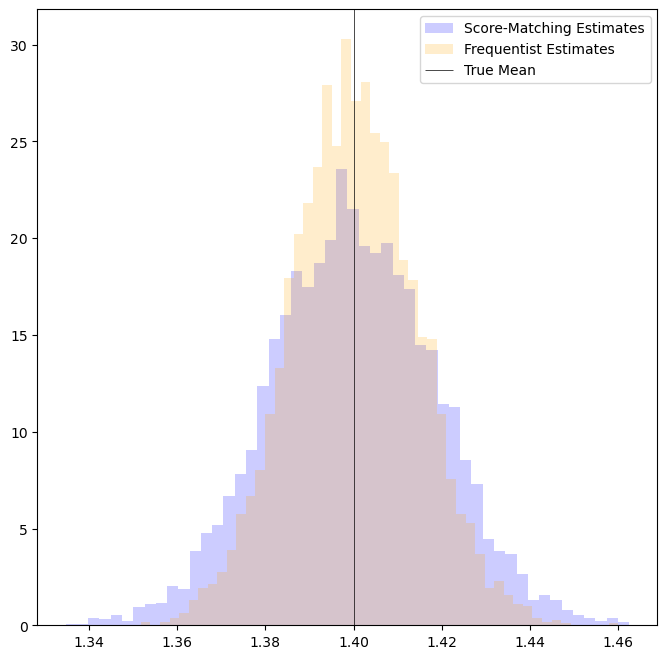

In [45]:
theta_prior_mean = 1.4
theta_prior_cov = 0.001
size=10000

theta_post_mean_estimates = [] 
theta_freq_mean_estimates = []

for i in range(5000):
    sample = np.random.exponential(scale=1/true_lamb, size=size)
    theta_post_mean_estimates.append(theta_post_mean_formula(theta_prior_mean, theta_prior_cov, sample))
    theta_freq_mean_estimates.append(1/sample.mean())


plt.figure(figsize=(8,8))
plt.hist(theta_post_mean_estimates, bins=50, density=True, alpha=0.2, color='blue', label="Score-Matching Estimates")
plt.hist(theta_freq_mean_estimates, bins=50, density=True, alpha=0.2, color='orange', label="Frequentist Estimates")
ymin, ymax = plt.ylim()
plt.vlines(true_lamb, ymin, ymax, color='black', linewidth=0.5, label="True Mean")
plt.ylim(ymin, ymax)
plt.legend()